<h1> Overall Approach </h1>

1. Clean up and EDA
2. Remove background from all images
3. Train model
4. Make classification on test data
5. Calculate error

In [30]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

**The U2Net is a popular technique used for salient object detection**
References - 
1. Research paper - https://arxiv.org/abs/2005.09007
2. Github Repo - https://github.com/shreyas-bk/U-2-Net

_The U2Net folder in this repo is a clone of above github repository_

In [31]:
from U2Net.data_loader import RescaleT
from U2Net.data_loader import ToTensor
from U2Net.data_loader import ToTensorLab
from U2Net.data_loader import SalObjDataset
from U2Net.model import U2NET 
from U2Net.model import U2NETP 

In [32]:
from IPython.display import display
from PIL import Image as Img

In [33]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

**Let's read the training dataset**

In [34]:
train_df = pd.read_csv('train2.csv')
train_df

image               species individual_id  \
0      00021adfb725ed.jpg    melon_headed_whale  cadddb1636b9   
1      000562241d384d.jpg        humpback_whale  1a71fbb72250   
2      0007c33415ce37.jpg    false_killer_whale  60008f293a2b   
3      0007d9bca26a99.jpg    bottlenose_dolphin  4b00fe572063   
4      00087baf5cef7a.jpg        humpback_whale  8e5253662392   
...                   ...                   ...           ...   
51028  fff639a7a78b3f.jpg                beluga  5ac053677ed1   
51029  fff8b32daff17e.jpg  cuviers_beaked_whale  1184686361b3   
51030  fff94675cc1aef.jpg            blue_whale  5401612696b9   
51031  fffbc5dd642d8c.jpg                beluga  4000b3d7c24e   
51032  fffdcd42312777.jpg    bottlenose_dolphin  4ddb2eeb5efb   

                       box  
0            2 116 802 665  
1        588 597 3504 1477  
2          0 453 3183 1589  
3           1 91 2636 1495  
4      1139 1590 3574 1913  
...                    ...  
51028                  NaN  
51029    2105 113 2294 157  
51030                  NaN  
51031                  NaN  
51032   1434 863 2884 1375  

[51033 rows x 4 columns]

**Let's do a little bit of cleanup**

References - 
1. https://www.kaggle.com/competitions/happy-whale-and-dolphin/discussion/305574
2. https://www.kaggle.com/c/happy-whale-and-dolphin/discussion/304633

In [35]:
## convert beluga, globis to whales
train_df.loc[train_df.species.str.contains('beluga'), 'species'] = 'beluga_whale'
train_df.loc[train_df.species.str.contains('globis'), 'species'] = 'short_finned_pilot_whale'
train_df.loc[train_df.species.str.contains('pilot_whale'), 'species'] = 'short_finned_pilot_whale'
train_df['class'] = train_df.species.map(lambda x: 'whale' if 'whale' in x else 'dolphin')

# fix duplicate labels
# https://www.kaggle.com/c/happy-whale-and-dolphin/discussion/304633
train_df['species'] = train_df['species'].str.replace('bottlenose_dolpin','bottlenose_dolphin')
train_df['species'] = train_df['species'].str.replace('kiler_whale','killer_whale')

In [36]:
train_df.head()

image             species individual_id                  box  \
0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9        2 116 802 665   
1  000562241d384d.jpg      humpback_whale  1a71fbb72250    588 597 3504 1477   
2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b      0 453 3183 1589   
3  0007d9bca26a99.jpg  bottlenose_dolphin  4b00fe572063       1 91 2636 1495   
4  00087baf5cef7a.jpg      humpback_whale  8e5253662392  1139 1590 3574 1913   

     class  
0    whale  
1    whale  
2    whale  
3  dolphin  
4    whale

## Let's see distribution of species 

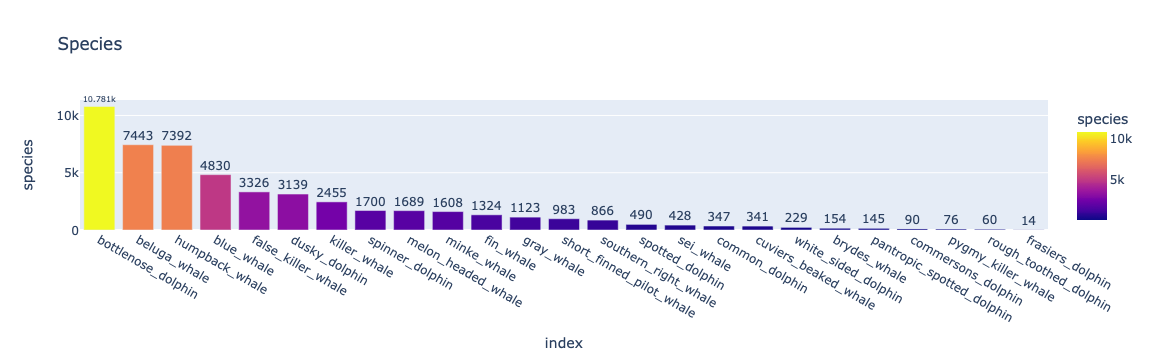

In [37]:
import plotly.express as px
data = train_df.species.value_counts().reset_index()
fig = px.bar(data, x='index', y='species', color='species',title='Species', text_auto=True)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

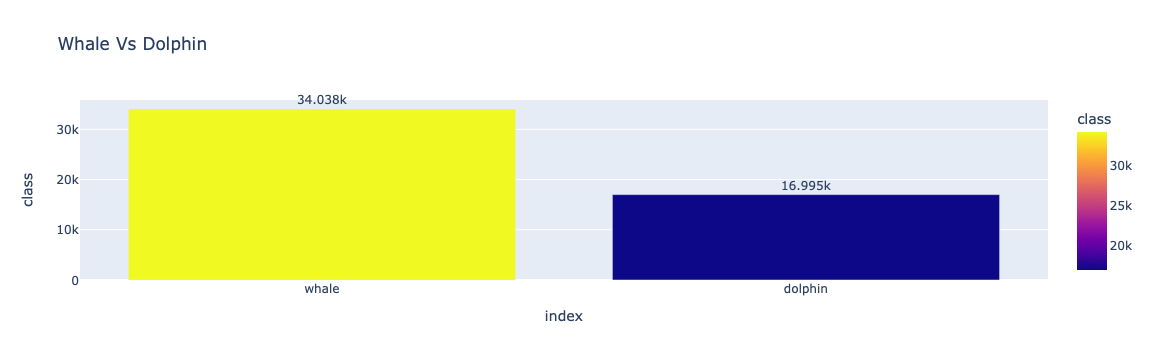

In [38]:
data = train_df['class'].value_counts().reset_index()
fig = px.bar(data, x='index', y='class', color='class', title='Whale Vs Dolphin', text_auto=True)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

In [39]:
train_df.individual_id.value_counts().head(10)

37c7aba965a5    400
114207cab555    168
a6e325d8e924    155
19fbb960f07d    154
c995c043c353    153
f195c38bcf17    146
ce6e37904aa4    145
ffbb4e585ff2    145
281504409737    143
bc1eb2241633    141
Name: individual_id, dtype: int64

**Obersation: We have multiple images for same individual**

# Let's Perform the background removal (Salient Object Detection)
References - 
1. https://www.kaggle.com/code/remekkinas/remove-background-salient-object-detection/notebook
2. https://github.com/shreyas-bk/U-2-Net
3. https://arxiv.org/abs/2005.09007 [Research Paper]


## 1. Take the candidates for background removal 

In [40]:
input_path = "cropped_train_images"
# img_to_draw = [ input_path + '/' + file for file in train_df.query("individual_id == '281504409737'").sample(25).image]
img_to_draw = [ input_path + '/' + file for file in train_df.image]

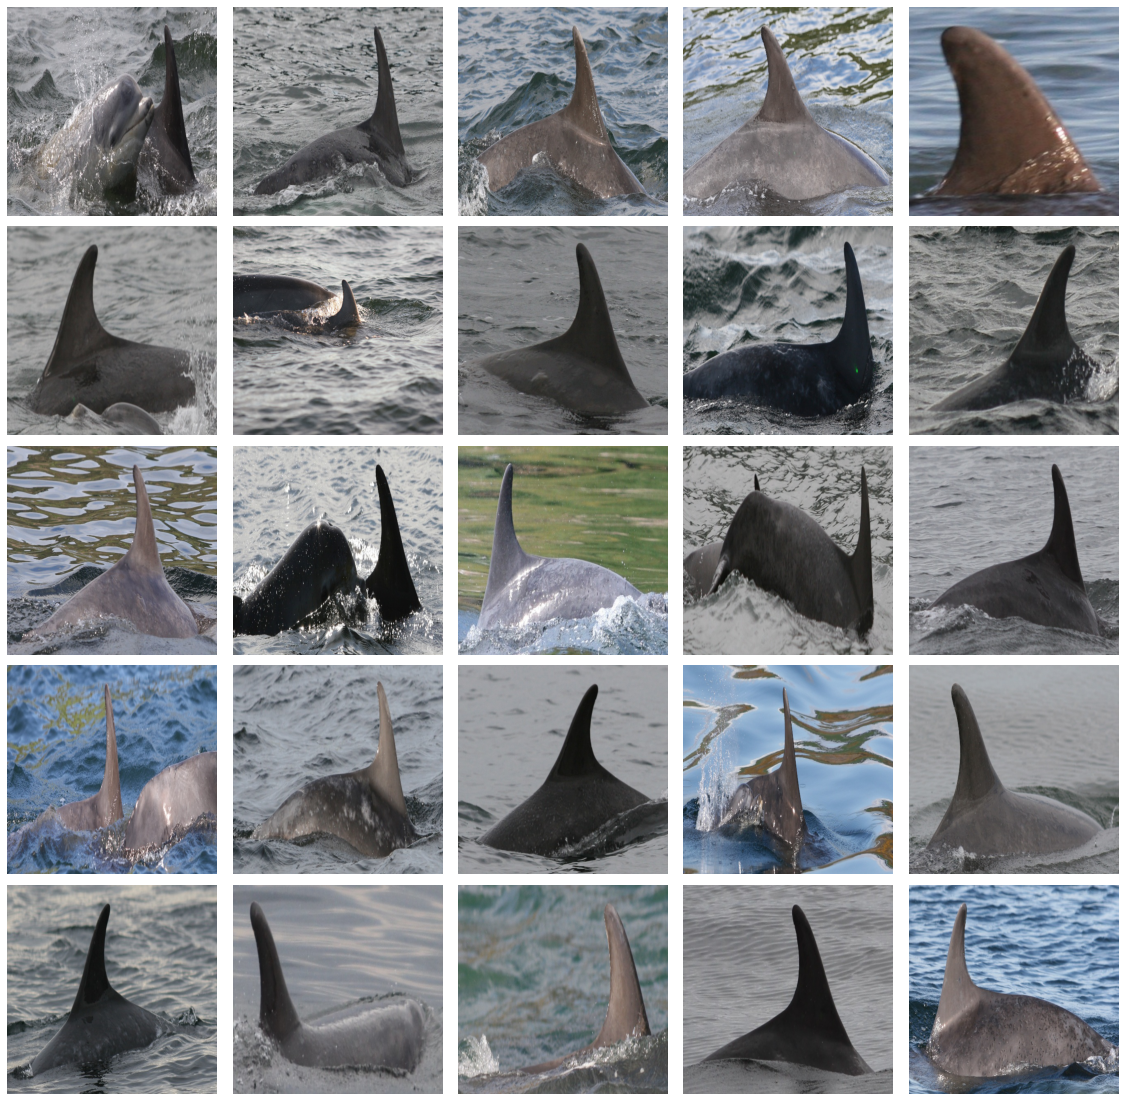

In [41]:
# fig, axes = plt.subplots(5, 5, figsize=(20,20))

# for idx, img in enumerate(img_to_draw):
#     i = idx % 5 
#     j = idx // 5
#     image = Img.open(img)
#     iar_shp = np.array(image).shape
#     axes[i, j].axis('off')
#     axes[i, j].imshow(image)
    
# plt.subplots_adjust(wspace=0.05, hspace=0.05)
# plt.show()

In [22]:
## 2. SOD - U2-Net Prediction

In [42]:
THRESHOLD = 0.3

In [43]:
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d-mi)/(ma-mi)
    return dn


def pred_unet(model, imgs):
    
    test_salobj_dataset = SalObjDataset(img_name_list = imgs, lbl_name_list = [], transform = transforms.Compose([RescaleT(320),ToTensorLab(flag=0)]))
    test_salobj_dataloader = DataLoader(test_salobj_dataset, batch_size=1, shuffle=False, num_workers = 1)
    
    for i_test, data_test in enumerate(test_salobj_dataloader):
        
        inputs_test = data_test['image']
        inputs_test = inputs_test.type(torch.FloatTensor)

        if torch.cuda.is_available():
            inputs_test = Variable(inputs_test.cuda())
        else:
            inputs_test = Variable(inputs_test)

        d1, d2, d3, d4, d5, d6, d7 = net(inputs_test)

        predict = d5[:,0,:,:]
        predict = normPRED(predict)
        
        del d1, d2, d3, d4, d5, d6, d7

        predict = predict.squeeze()
        predict_np = predict.cpu().data.numpy()

        # Masked image - using threshold you can soften/sharpen mask boundaries
        predict_np[predict_np > THRESHOLD] = 1
        predict_np[predict_np <= THRESHOLD] = 0
        mask = Img.fromarray(predict_np*255).convert('RGB')
        image = Img.open(imgs[0])
        imask = mask.resize((image.width, image.height), resample=Img.BILINEAR)
        back = Img.new("RGB", (image.width, image.height), (255, 255, 255))
        mask = imask.convert('L')
        im_out = Img.composite(image, back, mask)
        
        # Sailient mask 
        salient_mask = np.array(image)
        mask_layer = np.array(imask)        
        mask_layer[mask_layer == 255] = 50 # offest on RED channel
        salient_mask[:,:,0] += mask_layer[:,:, 0]
        salient_mask = np.clip(salient_mask, 0, 255) 
    
    return np.array(im_out), np.array(image), np.array(salient_mask), np.array(mask)

__Create a flag to use u2netp.pth (faster) or u2net.pth (slower but more accurate)__

In [44]:
UNET2_SMALL = False

In [45]:
%%capture

if UNET2_SMALL:
    model_dir = "./U2Net/u2netp.pth"  # Faster ... a lot (!) but less accurate
    net = U2NETP(3,1) 
else:
    model_dir = "./U2Net/u2net.pth"
    net = U2NET(3,1) 


if torch.cuda.is_available():
    net.load_state_dict(torch.load(model_dir))
    net.cuda()
else:        
    net.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))

net.eval()

## 3. U2-Net Result Visualization

KeyboardInterrupt: 

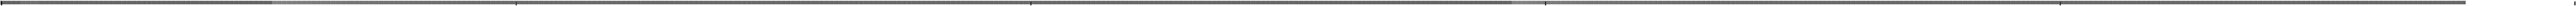

In [47]:
fig, axes = plt.subplots(51033, 1, figsize=(600,200))

for idx, img in enumerate(img_to_draw):
    image, im_oryg, sal_map, mask = pred_unet(net, [img_to_draw[idx]]) 
    result = np.concatenate((im_oryg, sal_map, image), axis=1)
    result_img = Img.fromarray(result)
    axes[idx].axis('off')
    axes[idx].imshow(result_img)

plt.subplots_adjust(wspace=0.05, hspace=0)
# plt.show()

## 4. Further improvements
remove the white area outside salient map

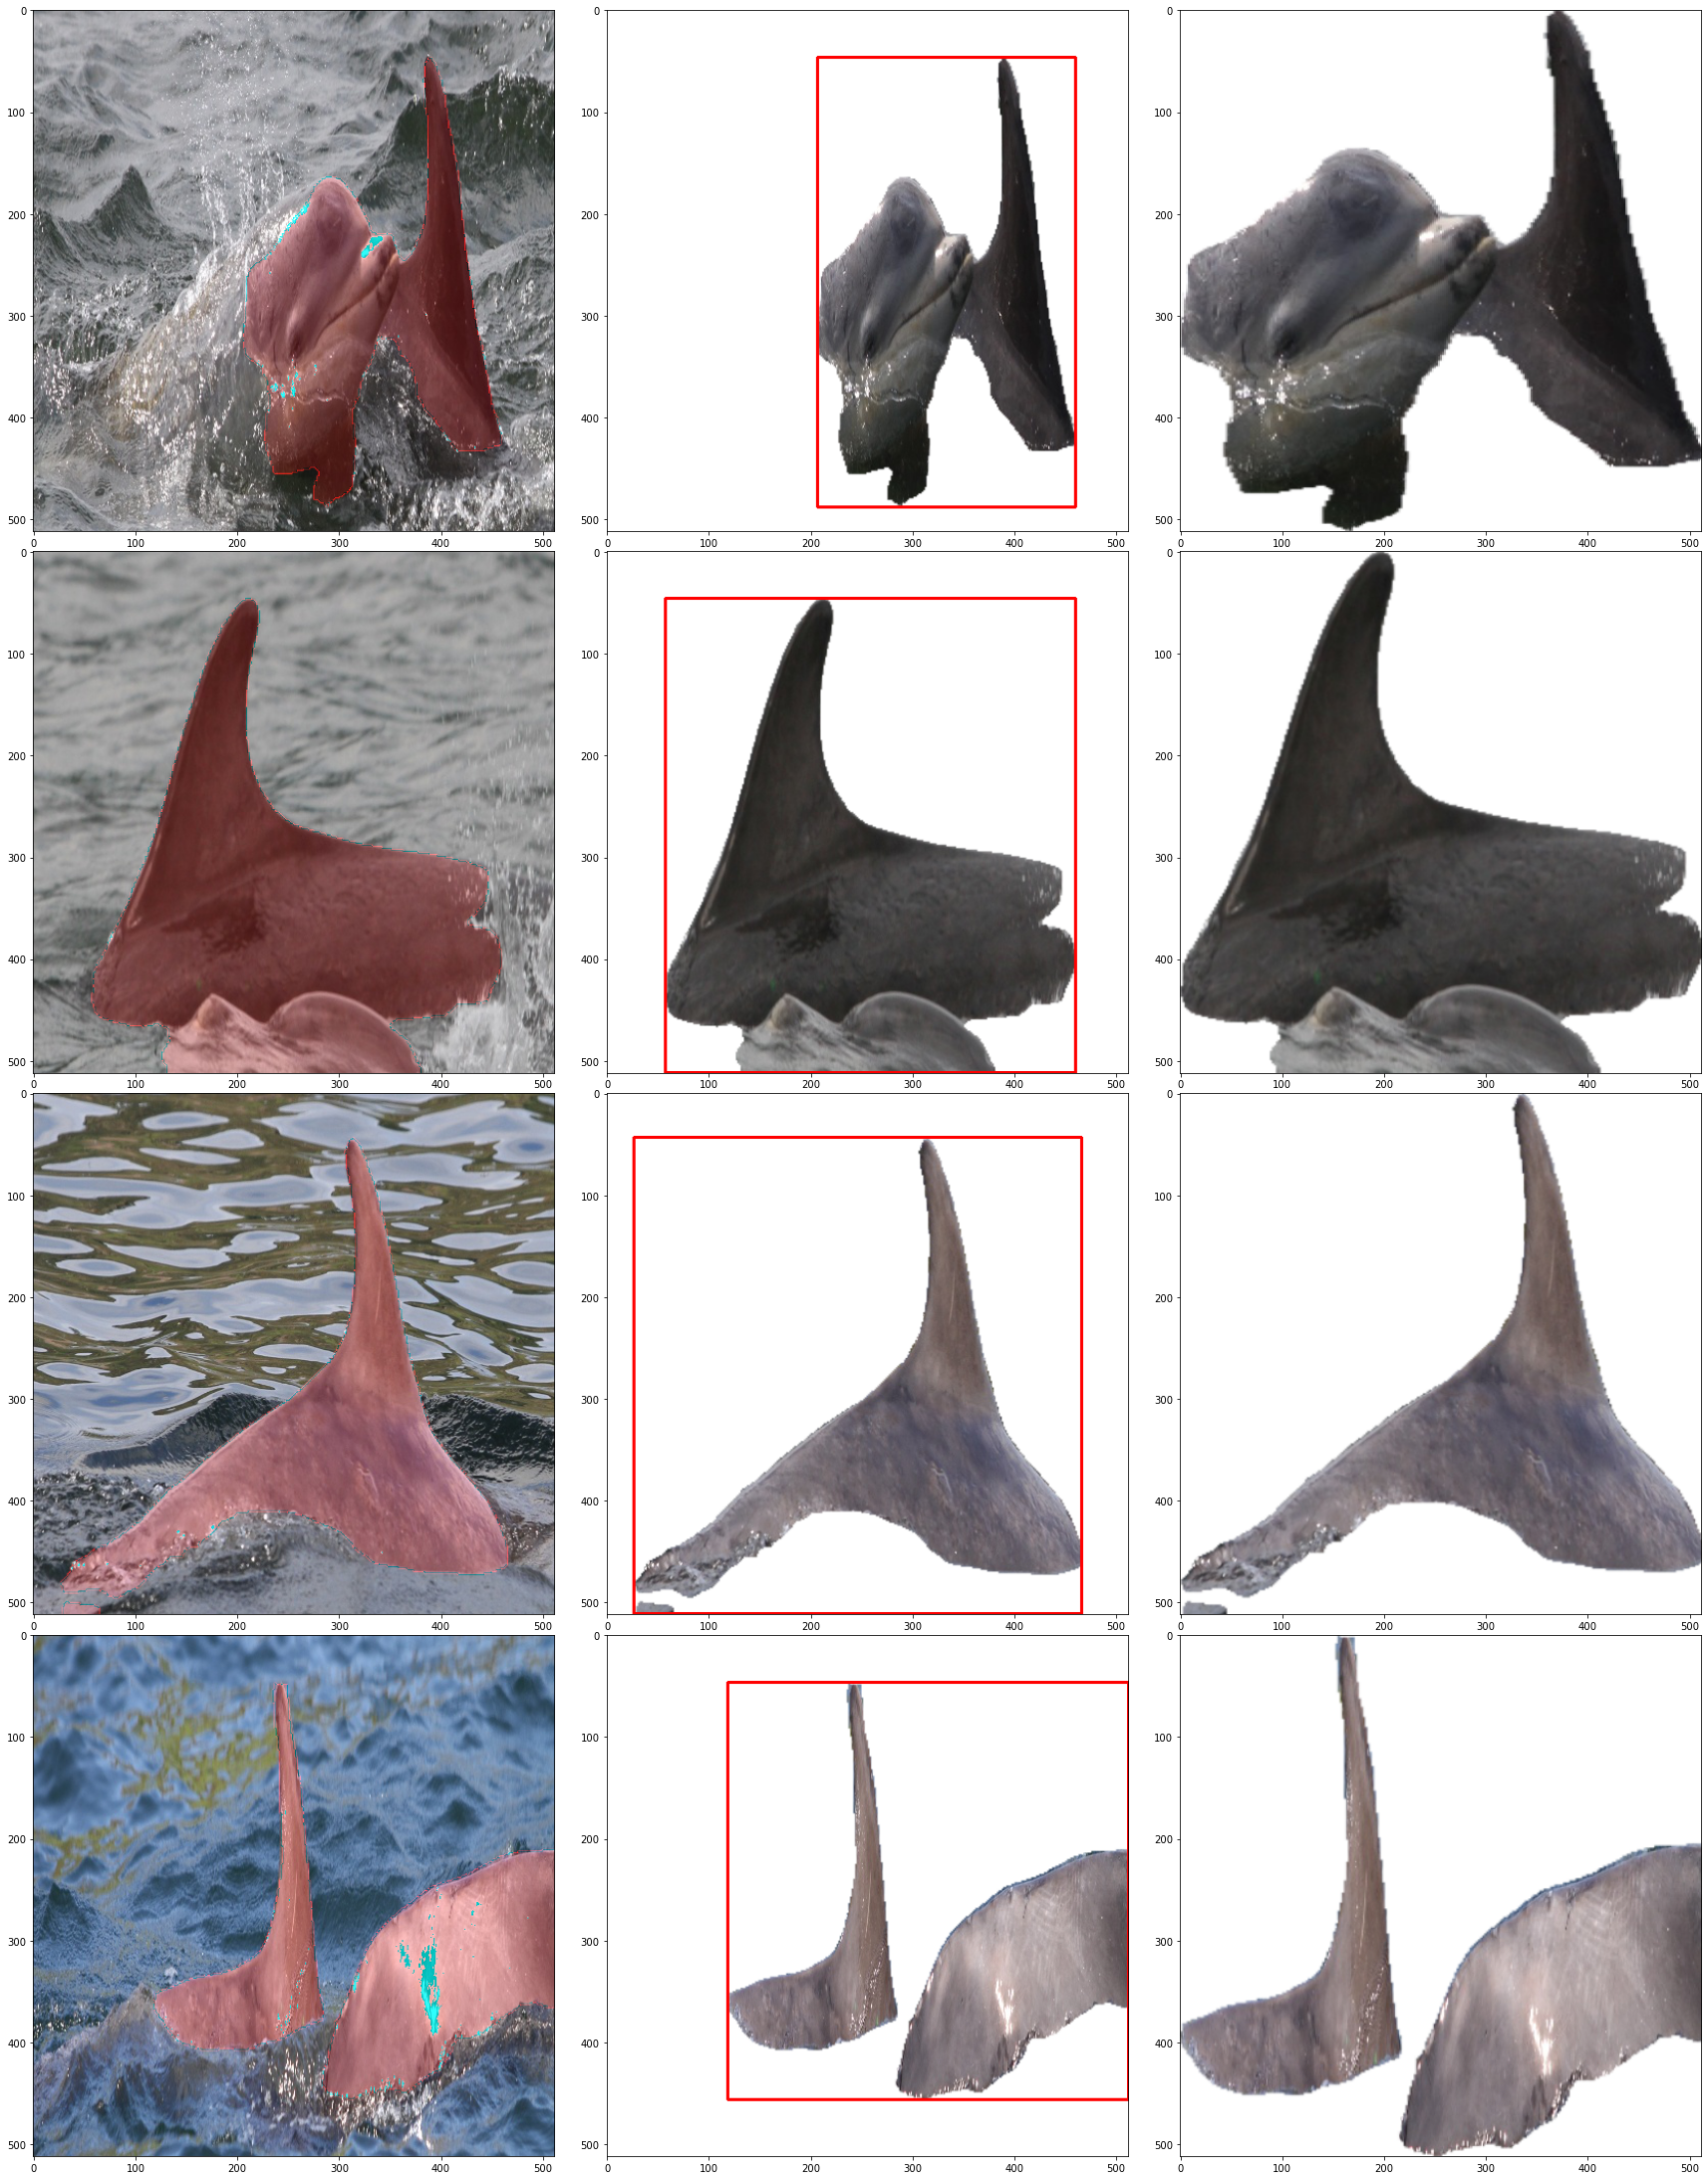

In [48]:
fig, axes = plt.subplots(4, 3, figsize=(30,40))

for idx, img in enumerate(img_to_draw):
    
    if idx > 3:
        break
        
    image, im_oryg, sal_map, mask = pred_unet(net, [img_to_draw[idx]])
    
    ymin = np.nonzero((mask[:] != 0).argmax(axis = 1))[0][0]
    ymax = np.nonzero((mask[:] != 0).argmax(axis = 1))[0][-1]
    xmin = np.nonzero((mask[:] != 0).argmax(axis = 0))[0][0]
    xmax = np.nonzero((mask[:] != 0).argmax(axis = 0))[0][-1]
    
    img = cv2.rectangle(image.copy(), (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    
    crop_img = image[ymin:ymax, xmin:xmax]
    crop_img = cv2.resize(crop_img, (image.shape[0], image.shape[1]), interpolation = cv2.INTER_AREA)
    
    result = np.concatenate((img, crop_img), axis=1)
    result_img = Img.fromarray(result)
    
    axes[idx, 0].imshow(Img.fromarray(sal_map))
    axes[idx, 1].imshow(Img.fromarray(img))
    axes[idx, 2].imshow(Img.fromarray(crop_img))

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.show()

## Alright we now have Salient Object Detection (SOD) 

**Next Steps**
1. Do SOD for all images
2. Throw it in the model (probably tensorflow or CNN) for training
3. Make predictions on test dataset